In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.5.2/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri):
    Data_DF = Open_File(Diri+Model+'_Data_SubsetA_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_SubsetA_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Begin_Time, Compl_Time, Peak_Time = [], [], [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
    Data_DF["Time(Z)"] = Time
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Peak Time"] = Peak_Time
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
def Month(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
        Month = New_Time.month
    except:
        Month = numpy.nan
    return (Month)

In [7]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [8]:
Num_Years = numpy.array([90,93,93])

In [9]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [10]:
# Define Bins
Lat_Bins = Create_Bins(10,60,5)
Lon_Bins = Create_Bins(-100,0,10)
SLP_Bins = Create_Bins(900,1010,10)

In [11]:
# Create Function to Plot ET Histograms
def ET_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Rela, Orient, Bins, Savefig, Figname):
    Fig = pyplot.figure(figsize=(16,8))
    Colours = ['limegreen', 'orange', 'red']
    Labels = ["Control", "RCP4.5", "RCP8.5"]
#
# Plot ET Initiation
    Axis = Fig.add_subplot(1,2,1)
    Var1 = "ET Begin " + Var
    pyplot.hist([Control_ET[Var1], RCP45_ET[Var1], RCP85_ET[Var1]], density=Rela, orientation=Orient, \
    bins=Bins, color=Colours, label=Labels)
    ET_Histo_Formatting(Var, Rela, Orient, Bins, "ET Initiation ")
#
# Plot ET Completion
    Axis = Fig.add_subplot(1,2,2)
    Var2 = "ET Complete " + Var
    pyplot.hist([Control_ET[Var2], RCP45_ET[Var2], RCP85_ET[Var2]], density=Rela, orientation=Orient, \
    bins=Bins, color=Colours, label=Labels)
    ET_Histo_Formatting(Var, Rela, Orient, Bins, "ET Completion ")
#
# Legend
    if Orient == 'horizontal':
        pyplot.legend(loc=4, fontsize=15)
    else:
        pyplot.legend(loc=2, fontsize=15)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [12]:
# Formatting Based on Variable
def ET_Histo_Formatting(Var, Rela, Orient, Bins, Title1):
# Ticks and Lims
    if Orient == 'horizontal':
        if Var == "Lat":
            if Rela == True:
                x_Min, x_Max, x_Width = 0, 0.07, 0.01
            else:
                x_Min, x_Max, x_Width = 0, 100, 10
        elif Var == "SLP":
            if Rela == True:
                x_Min, x_Max, x_Width = 0, 0.04, 0.005
            else:
                x_Min, x_Max, x_Width = 0, 110, 10
        pyplot.xticks(Create_Bins(x_Min, x_Max, x_Width))
        pyplot.xlim(x_Min, x_Max)
        pyplot.yticks(Bins)
        pyplot.ylim(numpy.min(Bins), numpy.max(Bins))
    else:
        if Var == "Lon":
            if Rela == True:
                y_Min, y_Max, y_Width = 0, 0.025, 0.005
            else:
                y_Min, y_Max, y_Width = 0, 70, 10
        pyplot.xticks(Bins)
        pyplot.xlim(numpy.min(Bins), numpy.max(Bins))
        pyplot.yticks(Create_Bins(y_Min, y_Max, y_Width))
        pyplot.ylim(y_Min, y_Max)
#
# Labels and Title
    if Rela == True:
        x_Label = "Proportion of Storms"
        Type = "Relative"
    else:
        x_Label = "Frequency of Storms"
        Type = "Absolute"
    if Orient == 'horizontal':
        pyplot.xlabel(x_Label, fontsize=18)
        if Var == "Lat":
            pyplot.ylabel("Latitude", fontsize=18)
        elif Var == "SLP":
            pyplot.ylabel("Sea Level Pressure (SLP)", fontsize=18)
    else:
        pyplot.ylabel(x_Label, fontsize=18)
        pyplot.xlabel("Longitude", fontsize=18)
    Title = Title1 + Var
#    Title = Title1 + Var + ' (' + Type + ')'
    pyplot.title(Title, fontsize=25)
#
# Gridlines
    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')

In [13]:
# Define Bins
B_Bins = Create_Bins(-45,135,7.5)
VLT_Bins = Create_Bins(-600,600,50)

In [14]:
# Create Subsets
def Create_Subsets(Data, Subset_Var):
    if Subset_Var == "SLP(hPa)":
        Subset_1 = Data[Data[Subset_Var] > 1000].reset_index()
        Subset_2 = Data[(Data[Subset_Var] > 990) & (Data[Subset_Var] <= 1000)].reset_index()
        Subset_3 = Data[(Data[Subset_Var] > 980) & (Data[Subset_Var] <= 990)].reset_index()
        Subset_4 = Data[Data[Subset_Var] <= 980].reset_index()
        Subset_Labels = ["SLP > 1000hPa", "SLP 990~1000hPa", "SLP 980~990hPa", "SLP <= 980hPa"]
    elif Subset_Var == "Lat":
        Subset_4 = Data[Data[Subset_Var] < 30].reset_index()
        Subset_3 = Data[(Data[Subset_Var] >= 30) & (Data[Subset_Var] < 35)].reset_index()
        Subset_2 = Data[(Data[Subset_Var] >= 35) & (Data[Subset_Var] < 40)].reset_index()
        Subset_1 = Data[Data[Subset_Var] >= 40].reset_index()
        Subset_Labels = ["Lat >= 40N", "Lat 35~40N", "Lat 30~35N", "Lat < 30N"]
    Subsets = [Subset_1, Subset_2, Subset_3, Subset_4]
    return (Subsets, Subset_Labels)

In [15]:
# Create Function to Plot Phase Space Parameter Histograms
def Phase_Param_Histogram(Control_Data, RCP45_Data, RCP85_Data, Subset_Var, B_Bins, VLT_Bins, Savefig, Figname):
    Colours = ['limegreen', 'orange', 'red']
    Labels = ["Control", "RCP4.5", "RCP8.5"]
#
# Create Subsets
    Control_Subsets, Subset_Labels = Create_Subsets(Control_Data, Subset_Var)
    RCP45_Subsets, Subset_Labels = Create_Subsets(RCP45_Data, Subset_Var)
    RCP85_Subsets, Subset_Labels = Create_Subsets(RCP85_Data, Subset_Var)
#
# Create Axes
    Fig = pyplot.figure(figsize=(16,30))
    Axes = Fig.subplots(4,2, sharex=False, sharey=False)
    for i in range(4):
# Plot B
        Axes[i][0].hist([Control_Subsets[i]["B"], RCP45_Subsets[i]["B"], RCP85_Subsets[i]["B"]], density=True, \
        orientation='horizontal', bins=B_Bins, color=Colours, label=Labels)
        Axes[i][0].plot([0,1], [15,15], color='black', linewidth=1.8, linestyle='--')
        Param_Histo_Formatting(Axes, i, 0, "B", B_Bins, Subset_Var, Subset_Labels[i])
# Plot VLT
        Axes[i][1].hist([Control_Subsets[i]["VLT"], RCP45_Subsets[i]["VLT"], RCP85_Subsets[i]["VLT"]], density=True, \
        orientation='vertical', bins=VLT_Bins, color=Colours, label=Labels)
        Axes[i][1].plot([0,0], [0,1], color='black', linewidth=1.8, linestyle='--')
        Param_Histo_Formatting(Axes, i, 1, "VLT", VLT_Bins, Subset_Var, Subset_Labels[i])
# Legend
        if i == 0:
            Axes[i][0].legend(loc=1, fontsize=15)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [16]:
# Formatting Based on Variable
def Param_Histo_Formatting(Axes, i, j, Var, Bins, Subset_Var, Subset_Label):
# Ticks and Lims
    if Var == "B":
        if Subset_Var == "SLP(hPa)":
            y_Min, y_Max, y_Width = -30, 75, 7.5
            x_Min, x_Max, x_Width = 0, 0.04, 0.005
        elif Subset_Var == "Lat":
            y_Min, y_Max, y_Width = -30, 90, 7.5
            x_Min, x_Max, x_Width = 0, 0.05, 0.005
    elif Var == "VLT":
        x_Min, x_Max, x_Width = -400, 400, 50
        y_Min, y_Max, y_Width = 0, 0.006, 0.001
    Axes[i][j].set_xticks(Create_Bins(x_Min, x_Max, x_Width))
    Axes[i][j].set_xlim(x_Min, x_Max)
    Axes[i][j].set_yticks(Create_Bins(y_Min, y_Max, y_Width))
    Axes[i][j].set_ylim(y_Min, y_Max)
#
# Labels and Title
    if j == 0:
        Axes[i][j].set_ylabel("B", fontsize=18)
        if i == 3:
            Axes[i][j].set_xlabel("Proportion of Datapoints", fontsize=18)
    elif j == 1:
        Axes[i][j].set_ylabel("Proportion of Datapoints", fontsize=18)
        if i == 3:
            Axes[i][j].set_xlabel("VLT", fontsize=18)
    Title = Var + ' (' + Subset_Label + ')'
    Axes[i][j].set_title(Title, fontsize=25)
#
# Gridlines
    Axes[i][j].grid(linewidth=0.5, color='silver', linestyle='-')

In [17]:
# Create Function to Plot ET Histograms For Month
def ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Rela, Orient, Bins, Savefig, Figname):
    Fig = pyplot.figure(figsize=(12,8))
    Colours = ['limegreen', 'orange', 'red']
    Labels = ["Control", "RCP4.5", "RCP8.5"]
#
# Find ET Begin Month
    Control_Month = Find_Month(Control_ET)
    RCP45_Month = Find_Month(RCP45_ET)
    RCP85_Month = Find_Month(RCP85_ET)
#
# Plot ET Initiation
    Axis = Fig.add_subplot(1,1,1)
    pyplot.hist([Control_Month, RCP45_Month, RCP85_Month], density=Rela, orientation=Orient, \
    bins=Bins, color=Colours, label=Labels)
    ET_Histo_Month_Formatting(Var, Rela, Orient, "ET Initiation ")
#
# Legend
    pyplot.legend(loc=2, fontsize=15)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [18]:
def Find_Month(ET):
    Months = numpy.zeros(len(ET))
    for i in range(len(ET)):
        Months[i] = ET["ET Begin Time"][i].month
    return (Months)

In [19]:
# Formatting Based on Variable
def ET_Histo_Month_Formatting(Var, Rela, Orient, Title1):
# Ticks and Lims
    if Orient == 'vertical':
        if Var == "Month":
            if Rela == True:
                y_Min, y_Max, y_Width = 0, 0.35, 0.05
            else:
                y_Min, y_Max, y_Width = 0, 90, 10
        pyplot.xticks(Create_Bins(1,12,1))
        pyplot.xlim(0.5,12.5)
        pyplot.yticks(Create_Bins(y_Min, y_Max, y_Width))
        pyplot.ylim(y_Min, y_Max)
#
# Labels and Title
    if Rela == True:
        x_Label = "Proportion of Storms"
        Type = "Relative"
    else:
        x_Label = "Frequency of Storms"
        Type = "Absolute"
    if Orient == 'vertical':
        pyplot.ylabel(x_Label, fontsize=18)
        pyplot.xlabel("Month", fontsize=18)
    Title = Title1 + Var
#    Title = Title1 + Var + ' (' + Type + ')'
    pyplot.title(Title, fontsize=25)
#
# Gridlines
    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')

In [20]:
# Plot Histograms

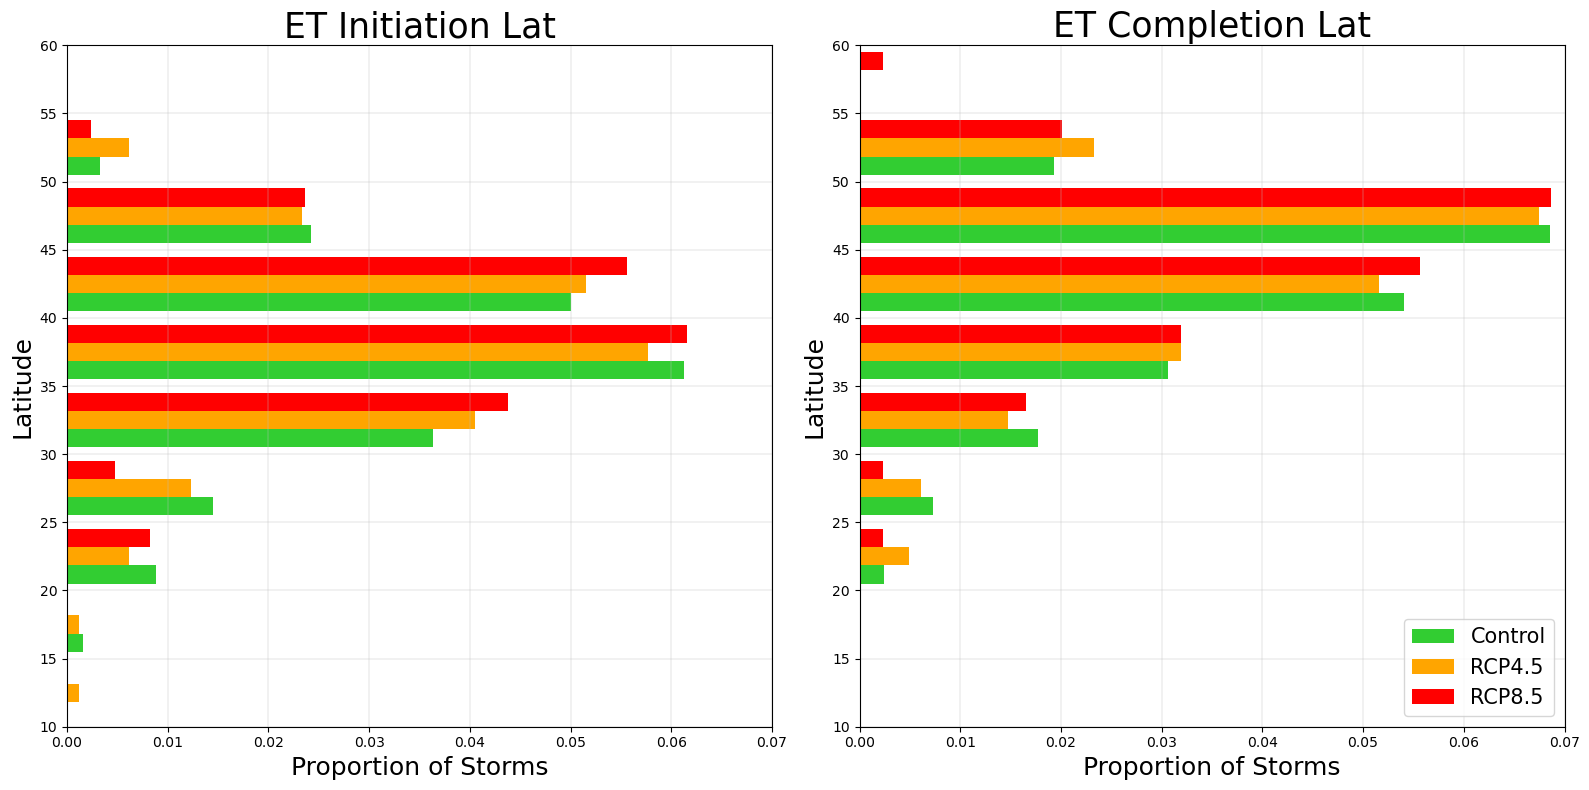

In [21]:
# ET Initiation and Completion Latitude (Relative)
ET_Histogram(Control_ET, RCP45_ET, RCP85_ET, "Lat", True, 'horizontal', Lat_Bins, True, 'ET_Latitude_Histo_Rela.png')

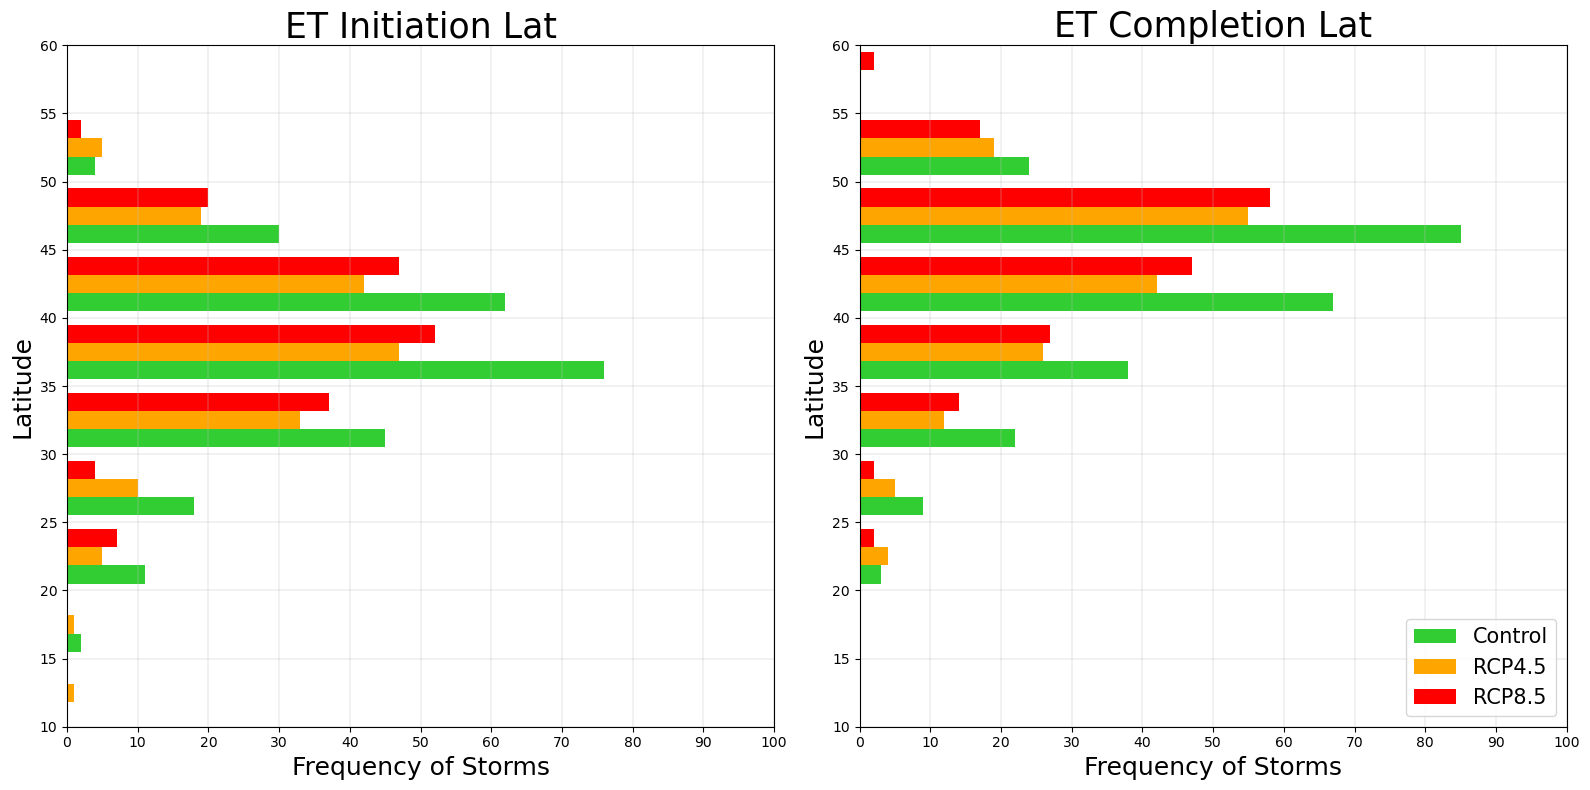

In [22]:
# ET Initiation and Completion Latitude (Absolute)
ET_Histogram(Control_ET, RCP45_ET, RCP85_ET, "Lat", False, 'horizontal', Lat_Bins, True, 'ET_Latitude_Histo_Abs.png')

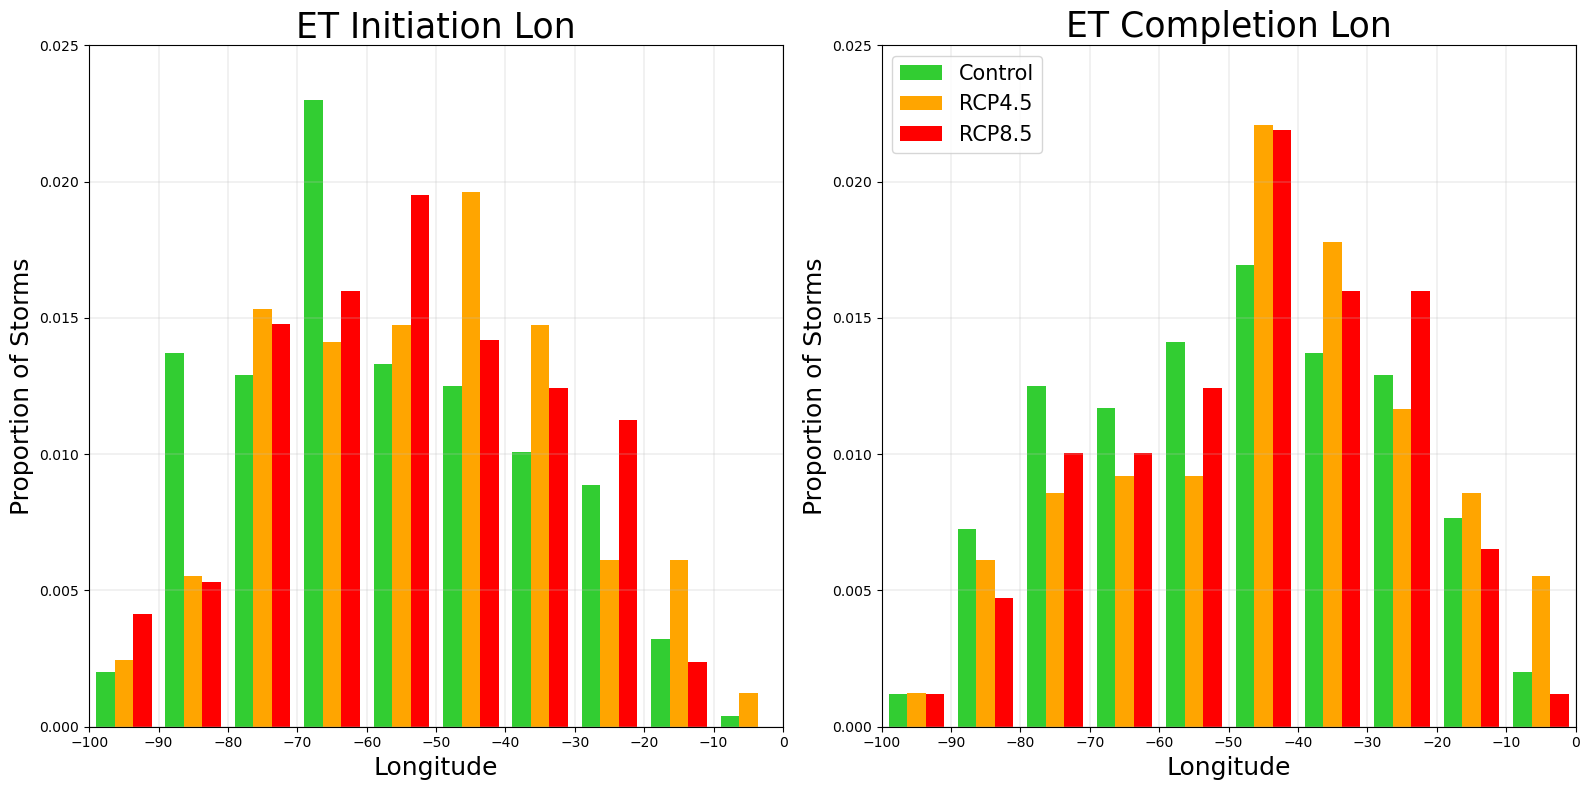

In [23]:
# ET Initiation and Completion Longitude (Relative)
ET_Histogram(Control_ET, RCP45_ET, RCP85_ET, "Lon", True, 'vertical', Lon_Bins, True, 'ET_Longitude_Histo_Rela.png')

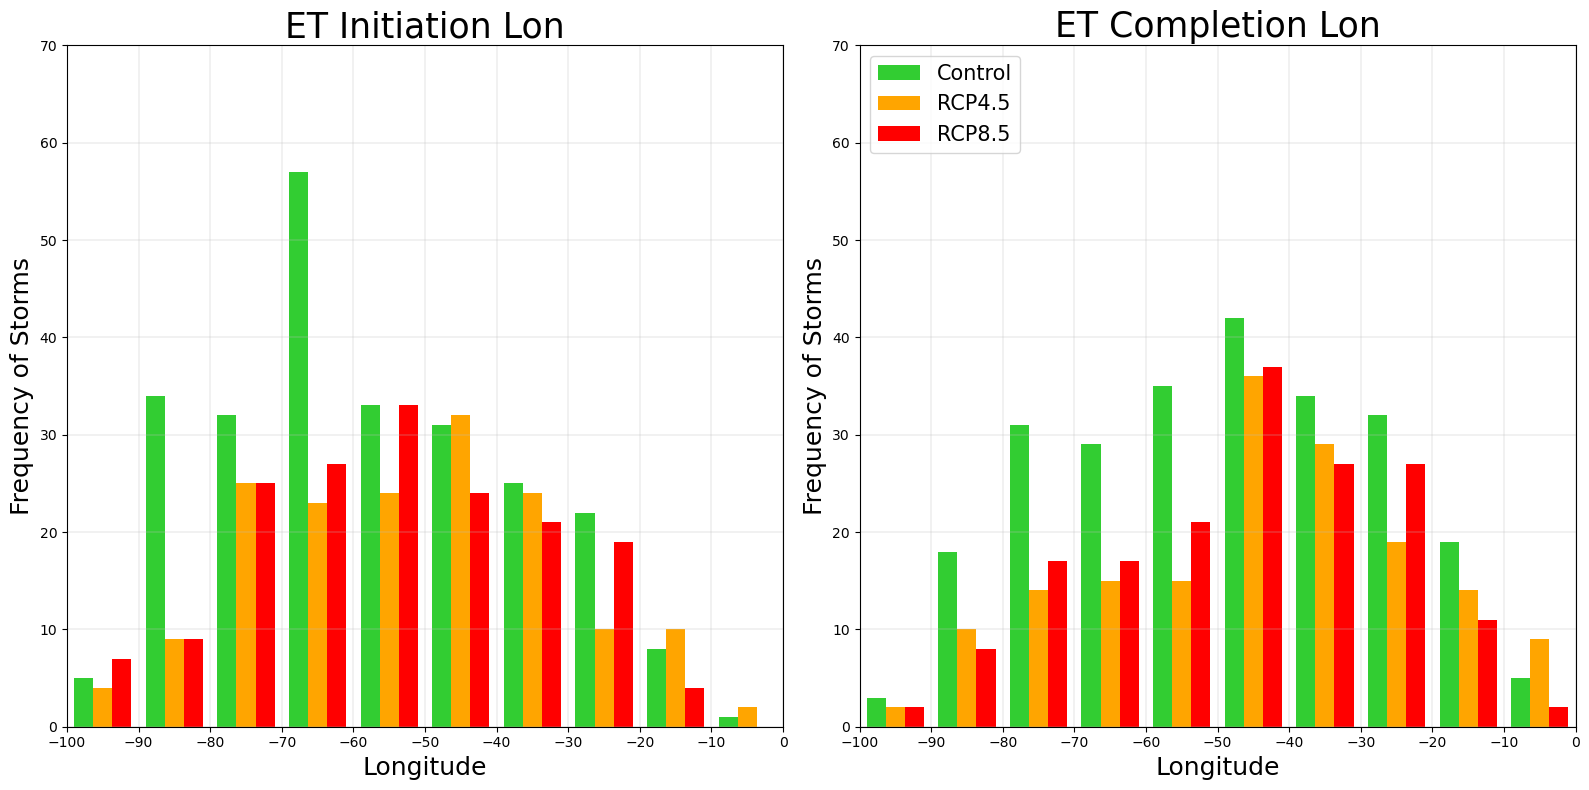

In [24]:
# ET Initiation and Completion Longitude (Absolute)
ET_Histogram(Control_ET, RCP45_ET, RCP85_ET, "Lon", False, 'vertical', Lon_Bins, True, 'ET_Longitude_Histo_Abs.png')

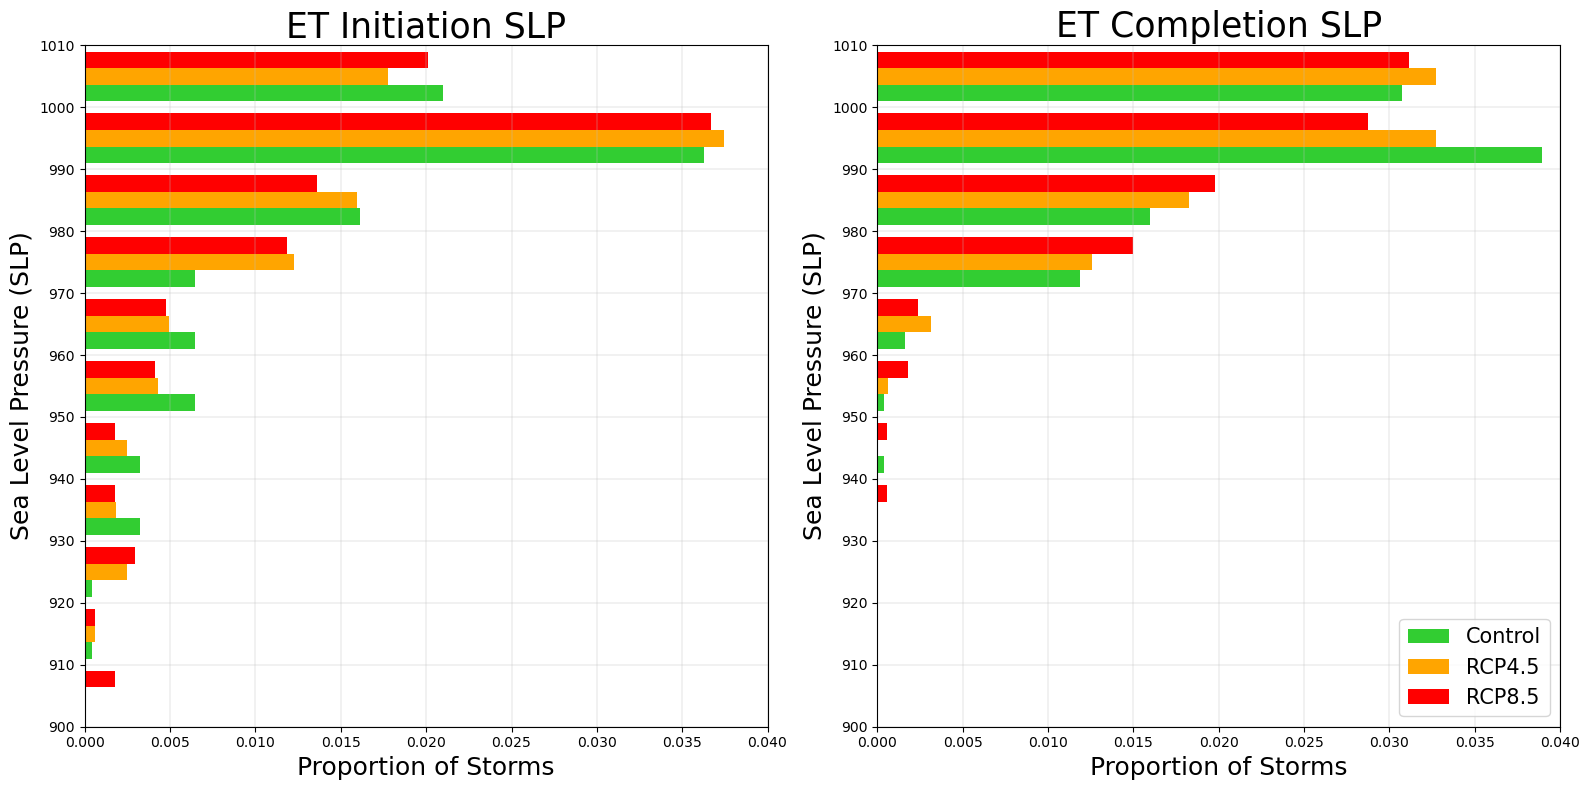

In [25]:
# ET Initiation and Completion SLP (Relative)
ET_Histogram(Control_ET, RCP45_ET, RCP85_ET, "SLP", True, 'horizontal', SLP_Bins, True, 'ET_SLP_Histo_Rela.png')

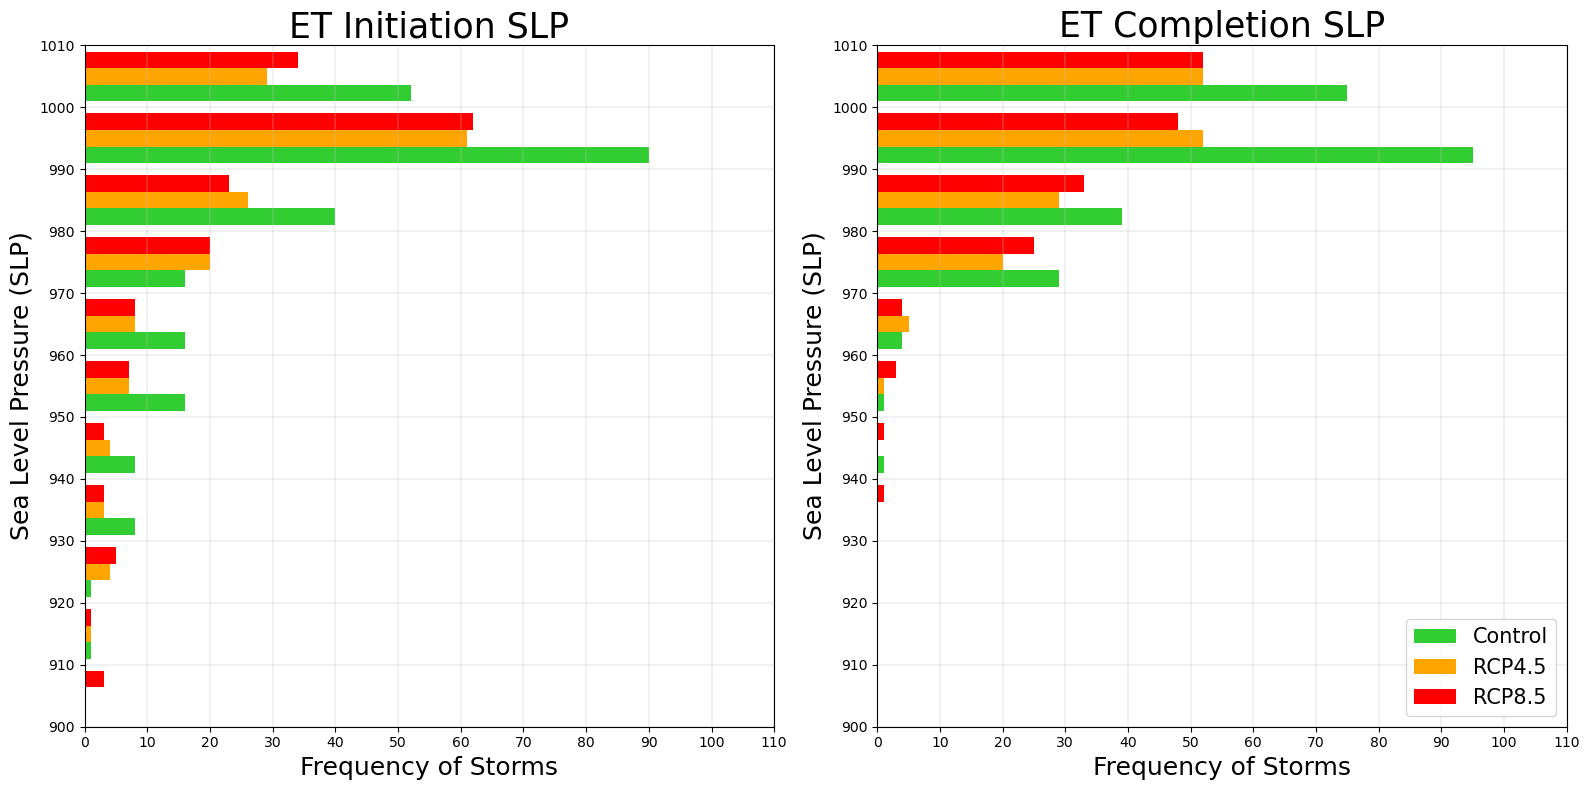

In [26]:
# ET Initiation and Completion Longitude (Absolute)
ET_Histogram(Control_ET, RCP45_ET, RCP85_ET, "SLP", False, 'horizontal', SLP_Bins, True, 'ET_SLP_Histo_Abs.png')

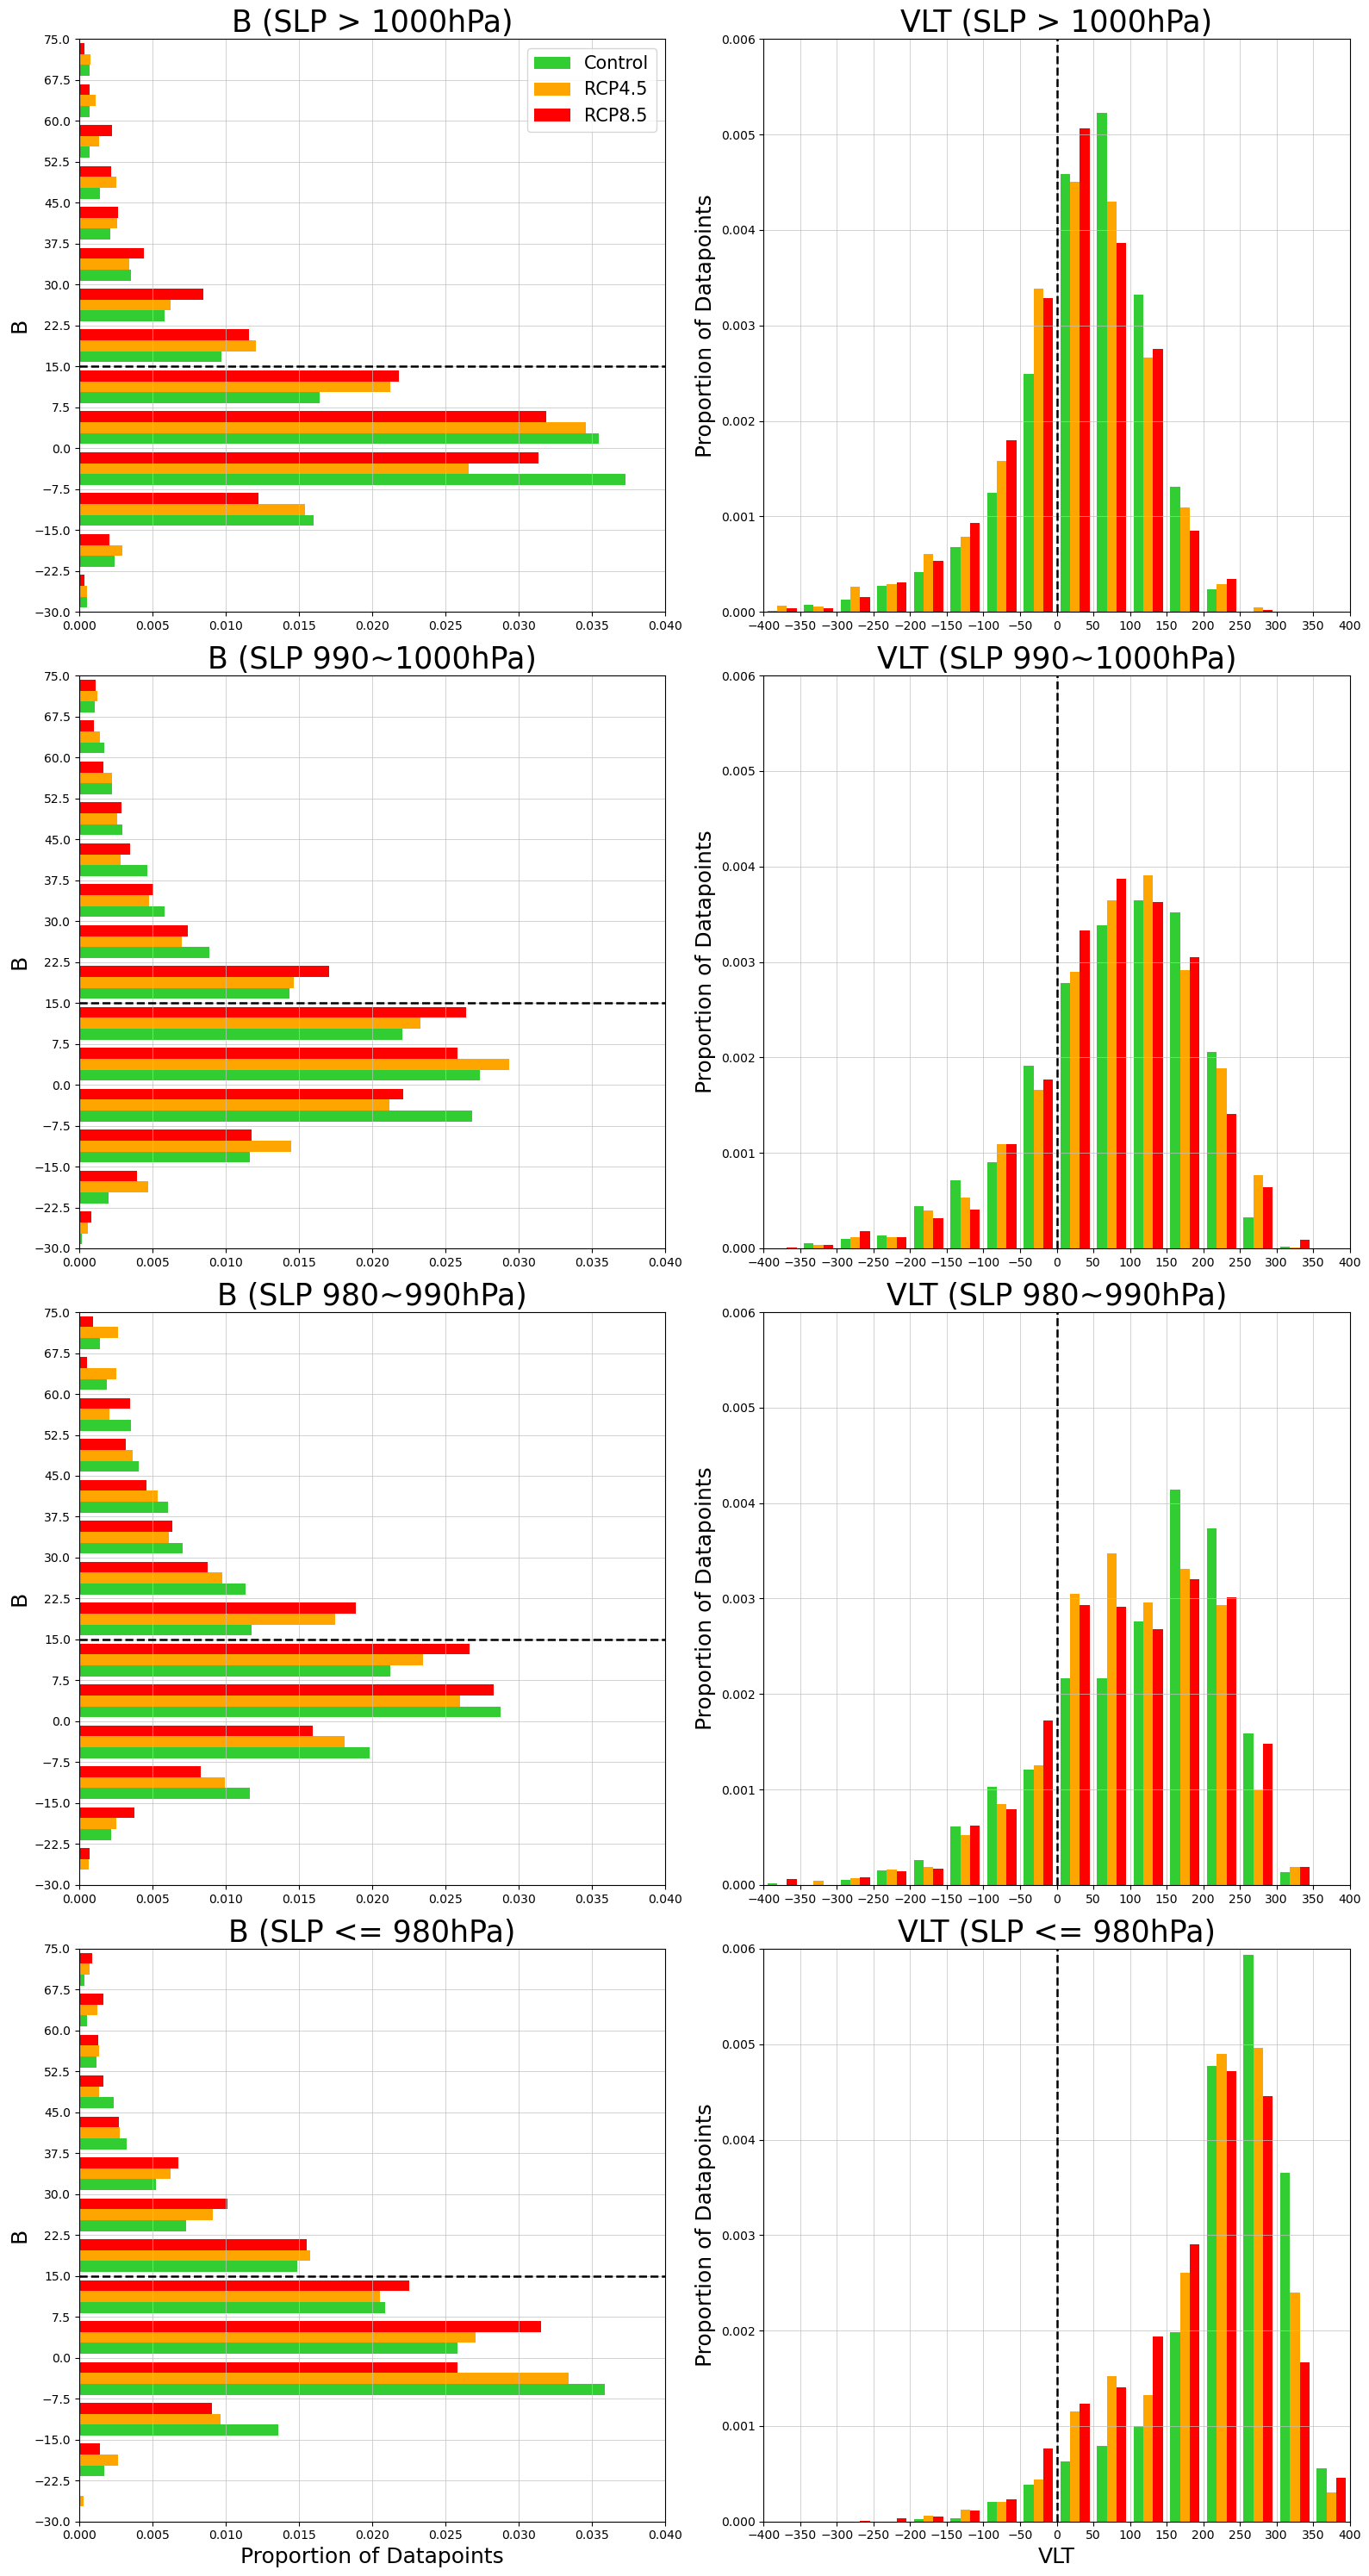

In [27]:
Phase_Param_Histogram(Control_Data, RCP45_Data, RCP85_Data, "SLP(hPa)", B_Bins, VLT_Bins, True, "Param_Subset_SLP_Histo.png")

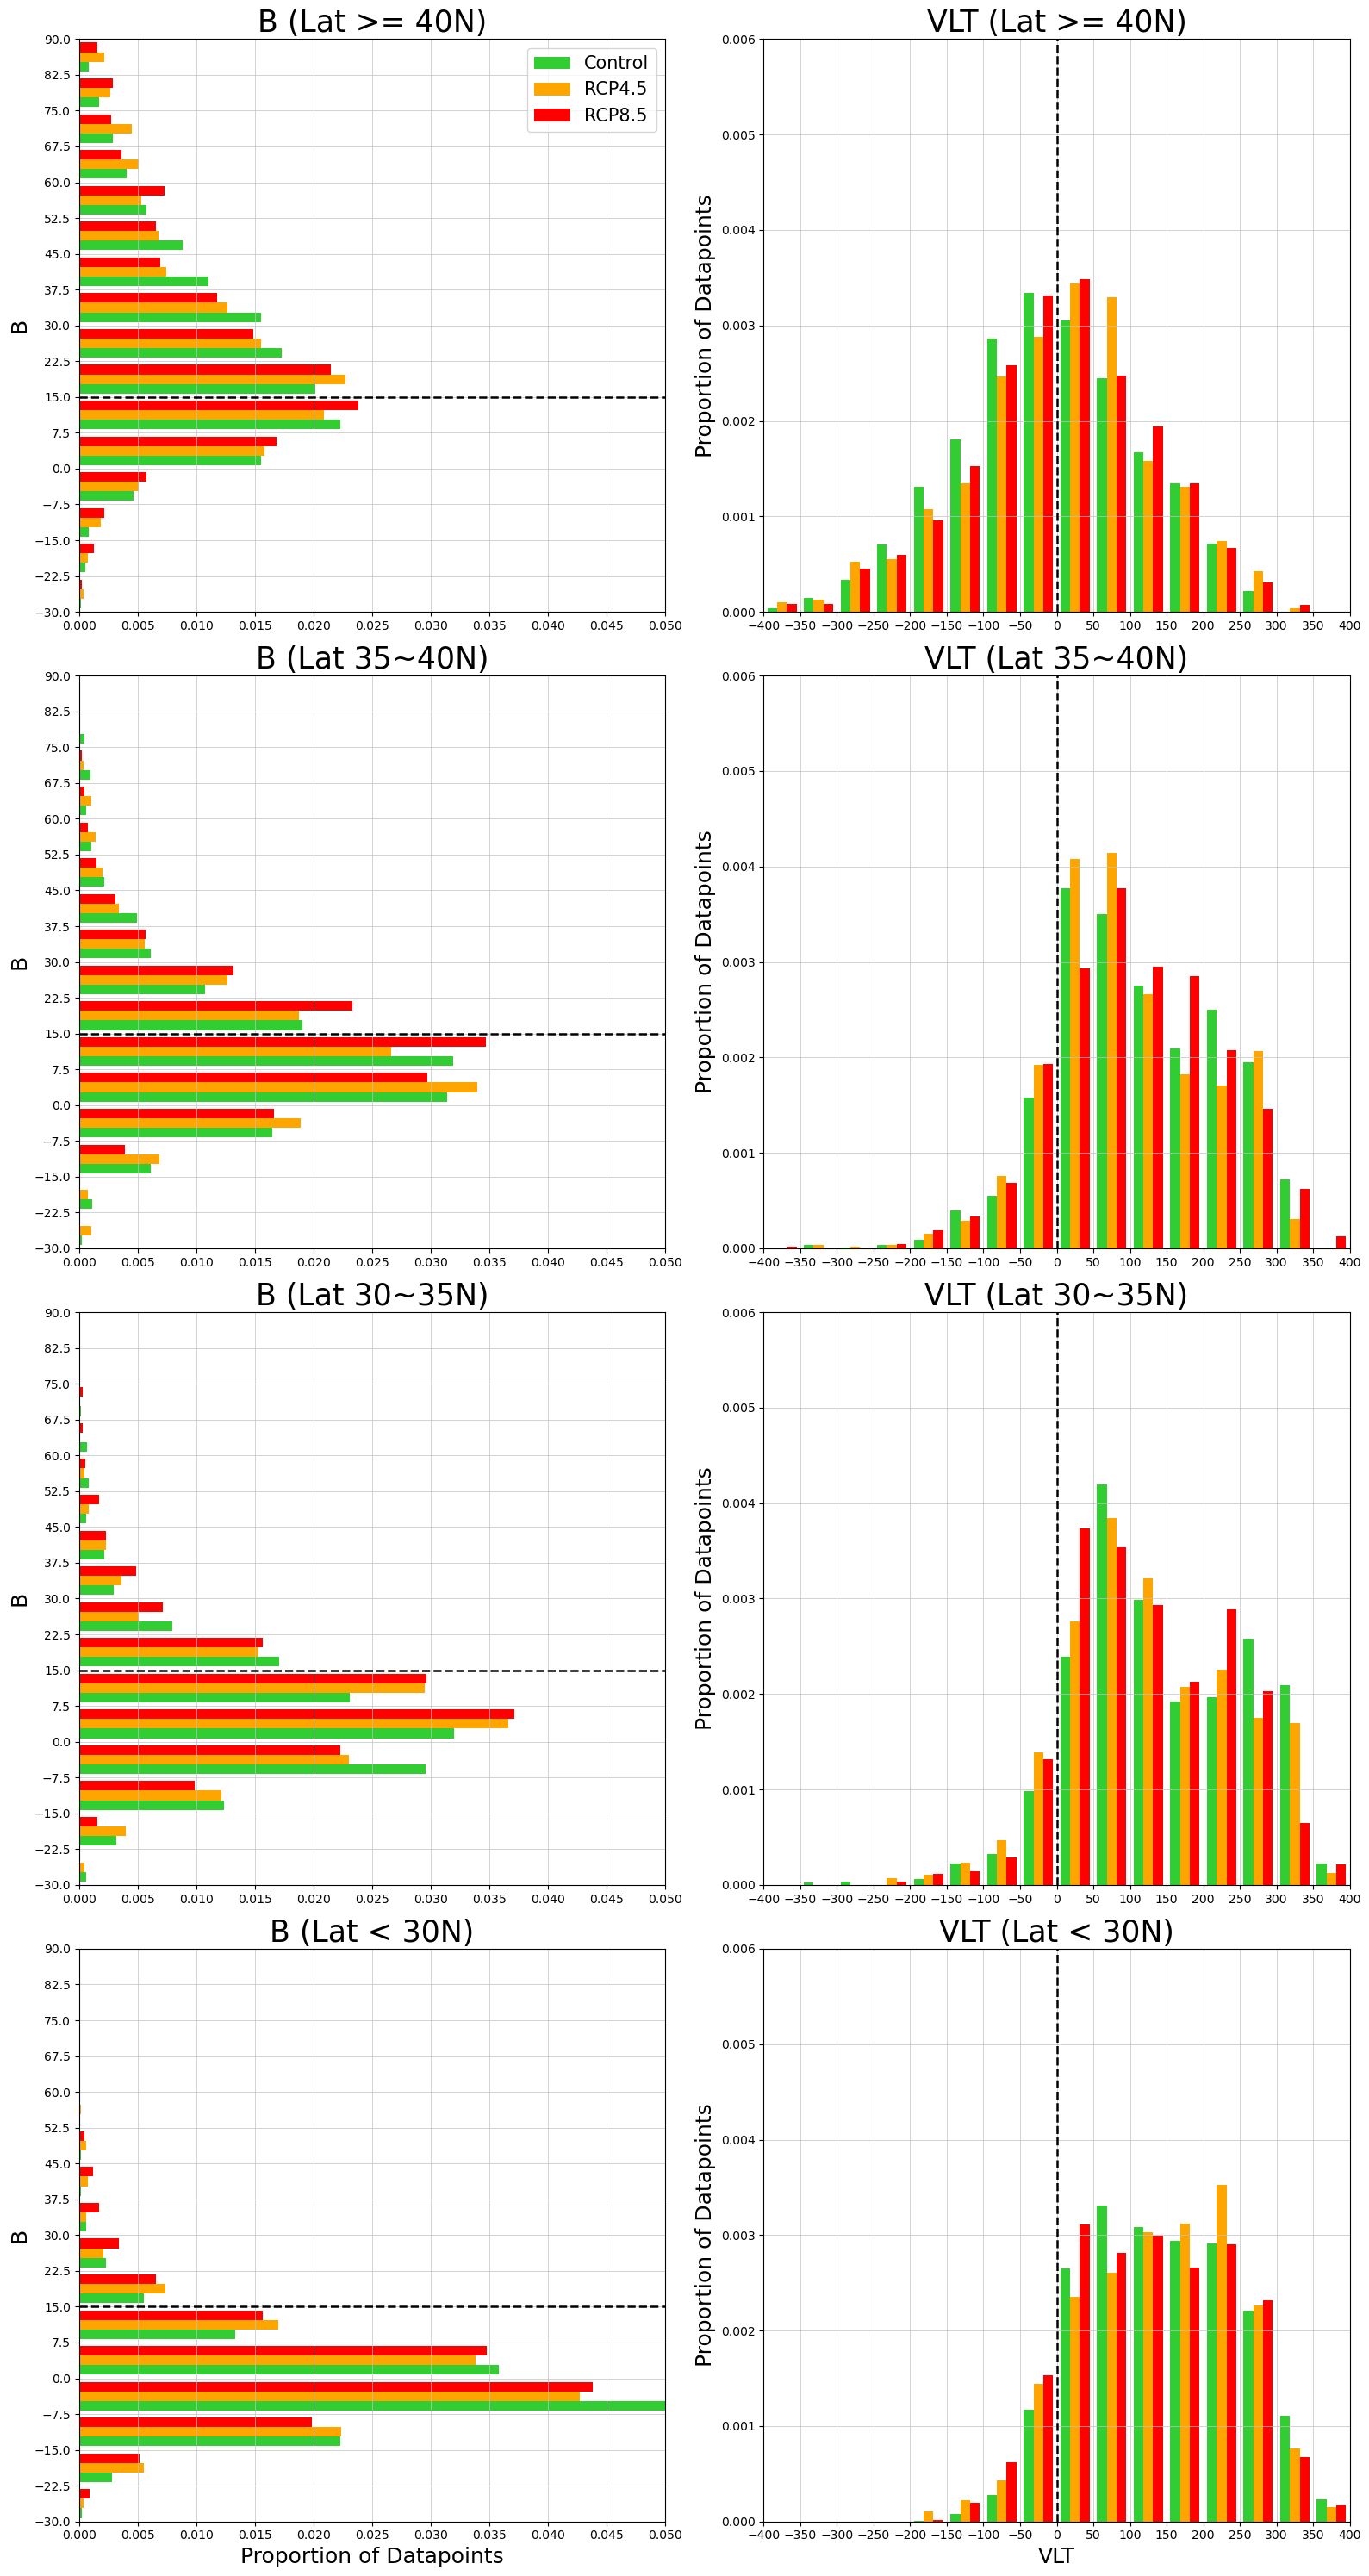

In [28]:
Phase_Param_Histogram(Control_Data, RCP45_Data, RCP85_Data, "Lat", B_Bins, VLT_Bins, True, "Param_Subset_Lat_Histo.png")

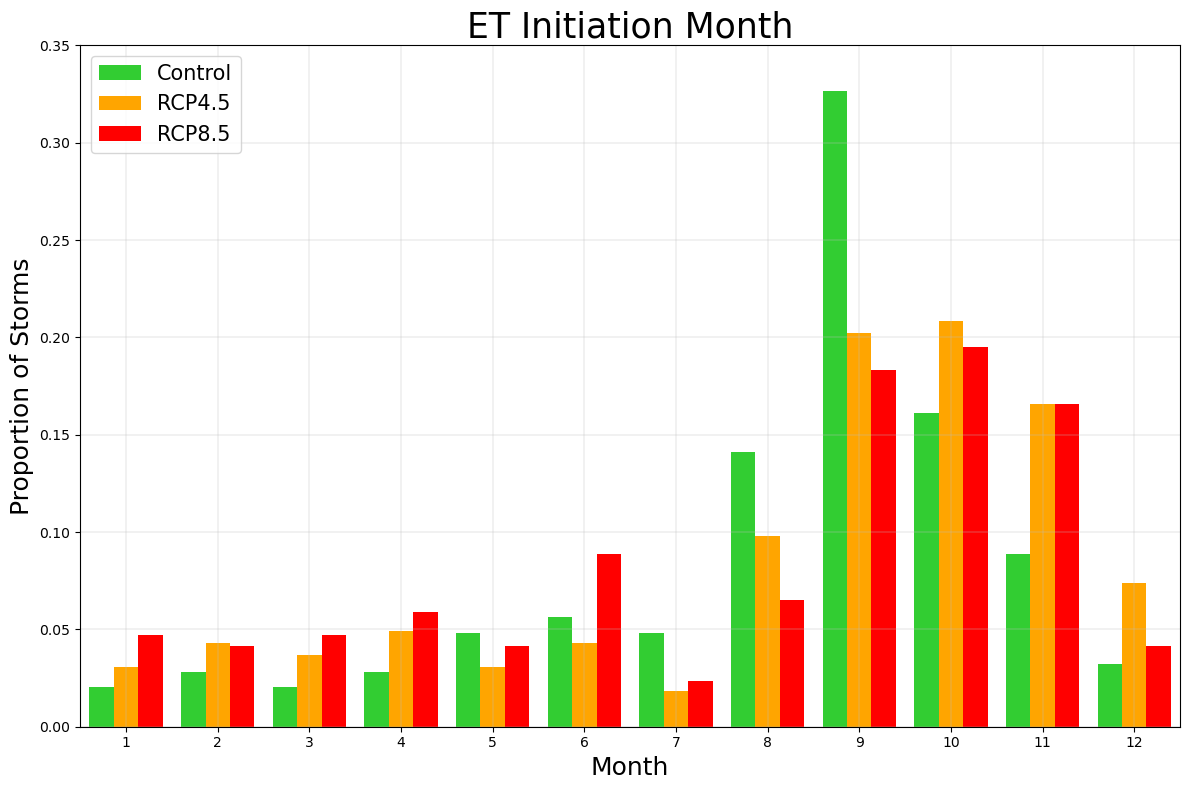

In [29]:
Month_Bins = Create_Bins(0.5,12.5,1)
ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, "Month", True, 'vertical', Month_Bins, True, 'ET_Month_Histo_Rela')

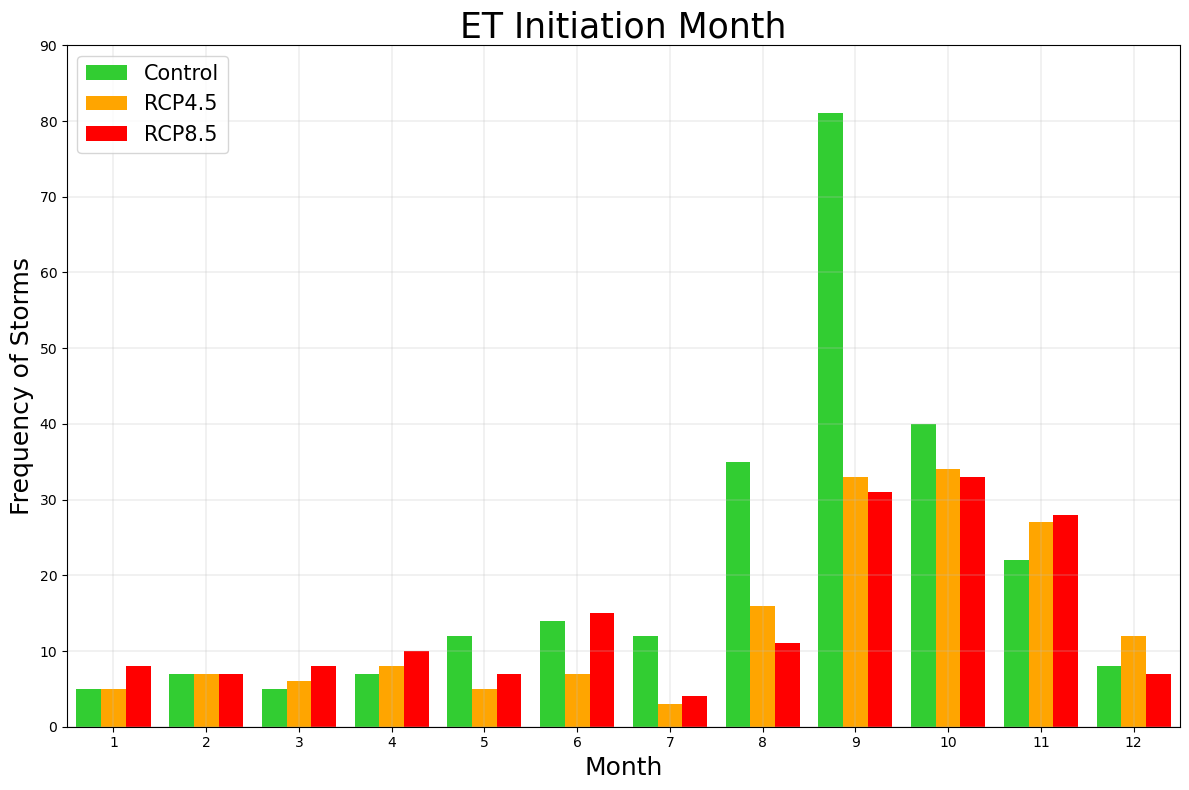

In [30]:
Month_Bins = Create_Bins(0.5,12.5,1)
ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, "Month", False, 'vertical', Month_Bins, True, 'ET_Month_Histo_Abs')